### **IAD-006 - Aprendizado de Máquinas II**
#### **Trabalho 1 - Árvores de decisão e Ensembles**
**Aluno: Ricardo Hideo Sahara**

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import pickle as pk
import os
from xgboost import XGBClassifier
from sklearn.tree import export_text

#### **Funções utilizadas no exercício**

##### Calcula a impureza total de uma árvore como a média das impurezas dos nós folhas ponderada pela quantidade da amostra no nó.

In [3]:
def gini_impurity_tree(decision_tree):
    gini_impurities = decision_tree.tree_.impurity
    samples_per_node = decision_tree.tree_.n_node_samples
    is_leaf = decision_tree.tree_.children_left == -1
    return sum(
        gini_impurities[i] * (samples_per_node[i] / samples_per_node[0]) 
        for i in range(len(gini_impurities)) if is_leaf[i]
    )

#### **Carrega o conjunto de dados de imagens de dígitos.**

In [4]:
# Carregar o dataset digits
digits = load_digits()
X = digits.data
y = digits.target

# Dividir o dataset em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Tamanho da matriz de dados de treino: ", X_train.shape)
print("Tamanho da matriz de dados de teste:", X_test.shape)

Tamanho da matriz de dados de treino:  (1437, 64)
Tamanho da matriz de dados de teste: (360, 64)


#### **Exercício 1 - Treinamento do modelo baseado em árvore de decisão**
Neste exercício, você irá treinar um modelo de árvore de decisão utilizando o conjunto de dados MNIST. O objetivo é entender como funciona o processo de treinamento de um modelo de árvore de decisão e como ajustar os parâmetros para melhorar o desempenho do modelo.

**Você irá:**
1. Carregar o conjunto de dados MNIST e pré-processar os dados, se necessário.
2. Selecionar a biblioteca ou framework que você irá utilizar (por exemplo, Scikit-learn e/ou XGBoost).
3. Configurar os parâmetros do modelo, como a profundidade da árvore, o número de características a considerar em cada nó, etc.
4. Treinar o modelo utilizando o conjunto de dados de treinamento.

*Dicas:*
- Certifique-se de que os dados estejam pré-processados corretamente antes de treinar o modelo.
- Ajuste os parâmetros do modelo, como a profundidade da árvore, para melhorar o desempenho do modelo.

##### **Resolução**

O código abaixo realiza uma busca dos melhores valores de parâmetros, dentro de um intervalo, de max_depth, min_samples_split e min_samples_leaf da árvore de decisão.

In [9]:
dt = DecisionTreeClassifier()

# Definir o espaço de busca dos hiperparâmetros
param_grid = {
    'splitter': ['best'],
    'criterion': ['gini'],                
    'max_depth': range(5, 30, 5),         
    'min_samples_split': range(2, 20, 1), 
    'min_samples_leaf': range(1, 20, 1)                
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Melhores hiperparâmetros: {best_params}")
decision_tree = grid_search.best_estimator_
y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

with open('models/decision_tree.pkl', 'wb') as pickle_file:
    pk.dump(decision_tree, pickle_file)


Fitting 5 folds for each of 1710 candidates, totalling 8550 fits


Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'splitter': 'best'}
Acurácia no conjunto de teste: 0.8389




Na saída acima são exibidos a precisão da árvore de decisão bem como os parâmetros para ter essa acurácia.

#### **Exercício 2 - Avaliação dos ganhos com a utilização de modelos Ensemble**
Neste exercício, você irá avaliar os ganhos obtidos ao utilizar modelos Ensemble em comparação com o modelo de árvore de decisão simples. Você irá treinar um modelo Ensemble e comparar os resultados com o modelo de árvore de decisão treinado anteriormente.

*Dicas:*
- Utilize diferentes tipos de modelos Ensemble, como Random Forest e XGBoost, para comparar os resultados.

##### **Resolução**

O código abaixo treina um modelo com o Random Forest e calcula sua precisão com os dados de teste.

In [41]:
rf = RandomForestClassifier(criterion='gini')
rf.fit(X_train, y_train)
with open('models/random_forest.pkl', 'wb') as pickle_file:
    pk.dump(rf, pickle_file)
print(f"Precisão do random forest: {rf.score(X_test, y_test):.4f}") 


Precisão do random forest: 0.9667


O código abaixo treina um modelo com o XGBoost e calcula sua precisão com os dados de teste.

In [43]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
with open('models/xgboost.pkl', 'wb') as pickle_file:
    pk.dump(xgb, pickle_file)
print(f"Precisão do XGBost: {xgb.score(X_test, y_test):.4f}") 

Precisão do XGBost: 0.9333


Abaixo segue a lista dos modelos ordenados do maior para o menor em termos de precisão:

1. Random Forest com 96,7% de precisão.

2. XGBoost com 93,3% de precisão.

3. Árvore de decisão com 83,3% de precisão.

#### **Exercício 3 - Visualização da árvore de decisão e Medida de Impureza**
Neste exercício, você irá explorar a estrutura da árvore de decisão e entender como a medida de impureza é utilizada para avaliar a qualidade das divisões nos nós da árvore. A medida de impureza é um conceito fundamental em árvores de decisão, pois ajuda a determinar a melhor forma de dividir os dados em subconjuntos menores e mais homogêneos.

**Você irá:**
1. Visualizar a árvore de decisão treinada no exercício anterior, utilizando ferramentas como o Scikit-learn ou o Graphviz.
2. Calcular a medida de impureza para diferentes conjuntos de dados e entender como ela impacta o desempenho do modelo.
3. Analisar como a medida de impureza afeta a escolha dos atributos para dividir os dados em cada nó da árvore.
4. Entender como a medida de impureza pode ser utilizada para evitar overfitting e melhorar a generalização do modelo.

##### **Resolução**

##### **Item 1**

Abaixo segue a visualização da árvore de decisão treinada no Exercício 1.

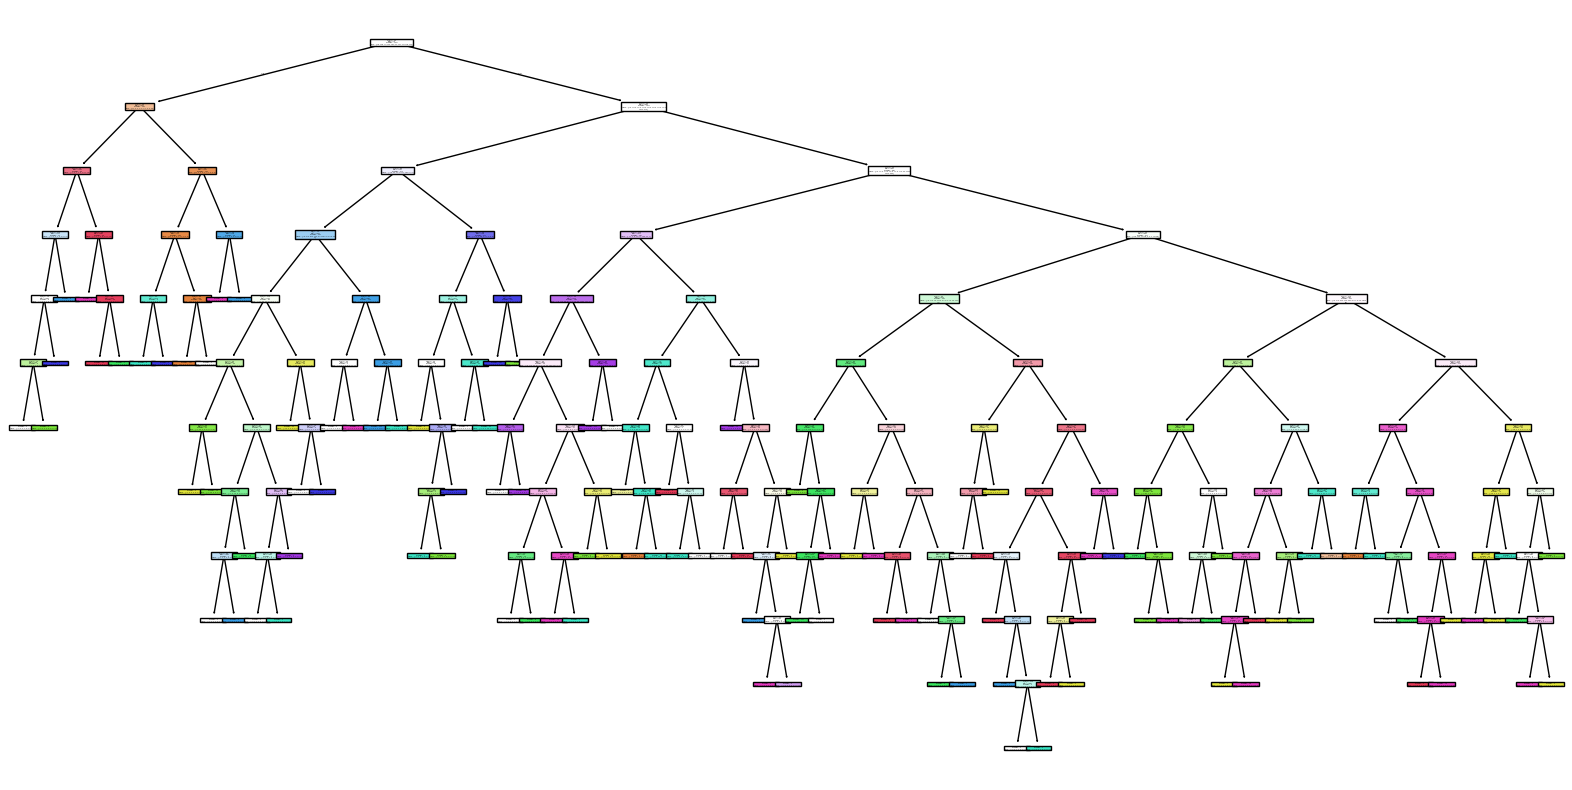

In [19]:
plt.figure(figsize=(20, 10))
tree.plot_tree(decision_tree, filled=True)
plt.show()

Para melhor visualização dos dados do nó, segue abaixo a árvore de decisão até a profundidade 1.

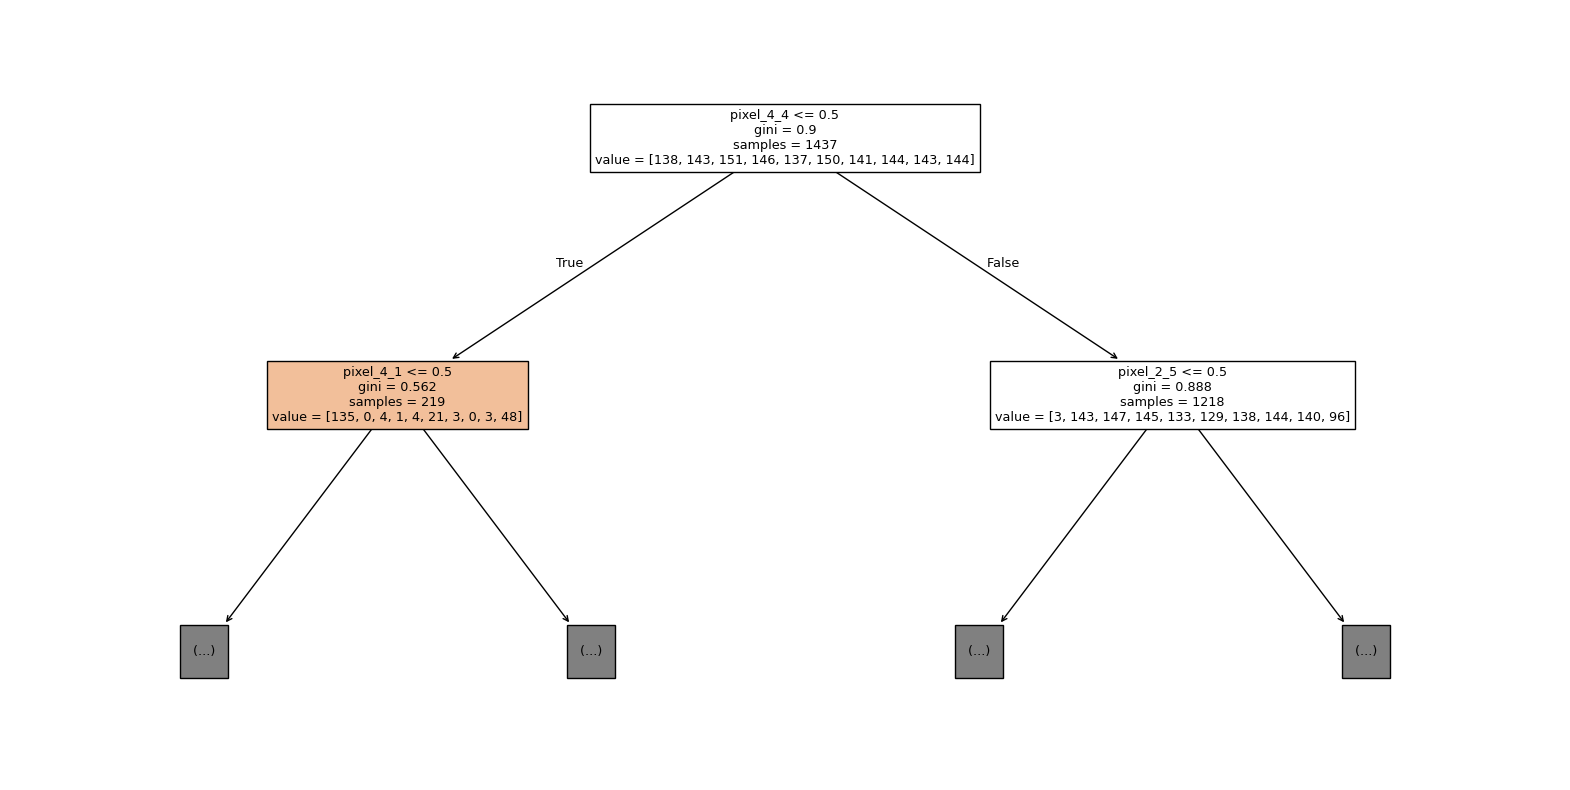

In [14]:
plt.figure(figsize=(20, 10))
tree.plot_tree(decision_tree, filled=True, max_depth=1, feature_names=digits['feature_names'])
plt.show()

##### **Item 2**


O código abaixo varia a quantidade mínima de amostra necessária para dividir um nó para observamos o comportamento da impureza em relação ao desempenho do modelo.

In [32]:
precisao = []
precisao_treino = []
impureza = []
split = []
for i in range(2, 50, 1):
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=15, min_samples_leaf=1, min_samples_split=i)
    dt.fit(X_train, y_train)
    precisao.append(dt.score(X_test, y_test))
    precisao_treino.append(dt.score(X_train, y_train))
    impureza.append(gini_impurity_tree(dt))
    split.append(i)

O gráfico abaixo mostra a relação entre a impureza total de Gini e a precisão do modelo a partir das árvores de decisão contruídas no código acima.

Podemos observar que a medida que a impureza total de Gini aumenta, a precisão do modelo diminui.

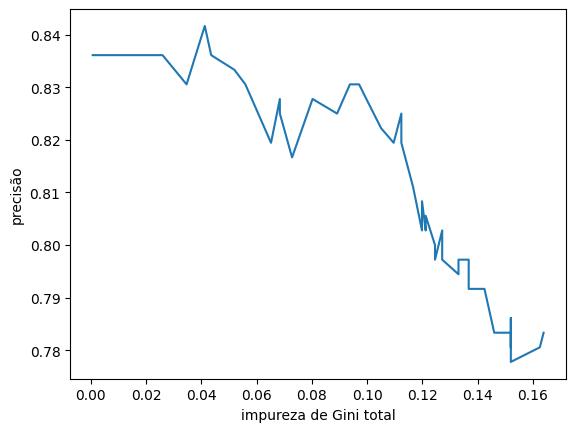

In [104]:
plt.plot(impureza, precisao)
plt.xlabel('impureza de Gini total')
plt.ylabel('precisão')
plt.show()

##### **Item 3**

Utilizando as árvores de decisão construídas no item 2, podemos relacionar a quantidade mínima de split e a impureza total de Gini.

Podemos observar que a medida que a quantidade mínima de amostra para a divisão aumenta, a impureza total de Gini também aumenta. Isso implica que o atributo escolhido para a divisão precisar ter uma quantidade relevante para ser escolhido para a quebra.

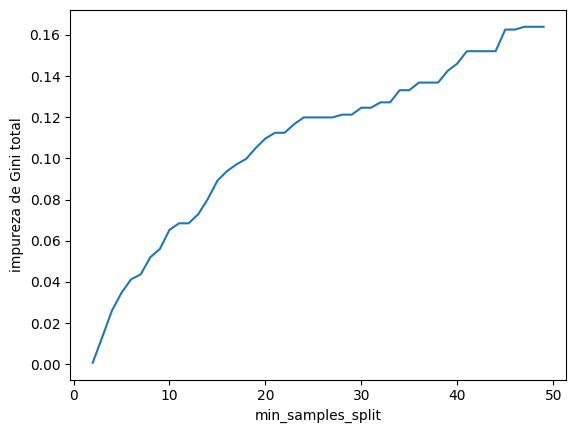

In [105]:
plt.plot(split, impureza)    
plt.xlabel('min_samples_split')
plt.ylabel('impureza de Gini total')
plt.show()

In [18]:
print(export_text(decision_tree, feature_names=digits['feature_names'], max_depth=2 ))

|--- pixel_4_4 <= 0.50
|   |--- pixel_4_1 <= 0.50
|   |   |--- pixel_2_5 <= 6.00
|   |   |   |--- truncated branch of depth 4
|   |   |--- pixel_2_5 >  6.00
|   |   |   |--- truncated branch of depth 3
|   |--- pixel_4_1 >  0.50
|   |   |--- pixel_0_6 <= 1.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- pixel_0_6 >  1.50
|   |   |   |--- truncated branch of depth 2
|--- pixel_4_4 >  0.50
|   |--- pixel_2_5 <= 0.50
|   |   |--- pixel_5_2 <= 8.50
|   |   |   |--- truncated branch of depth 8
|   |   |--- pixel_5_2 >  8.50
|   |   |   |--- truncated branch of depth 4
|   |--- pixel_2_5 >  0.50
|   |   |--- pixel_7_4 <= 7.50
|   |   |   |--- truncated branch of depth 8
|   |   |--- pixel_7_4 >  7.50
|   |   |   |--- truncated branch of depth 11



##### **Item 4**

Para este item, será utilizado as simulações realizadas no item 2.

O gráfico abaixo mostra a relação entre a precisão do teste e a diferença entre a precisão do teste e do treino.

Observamos que diminuindo o overfitting implica na diminuição na precisão do modelo, mas com valores razoáveis de precisão.

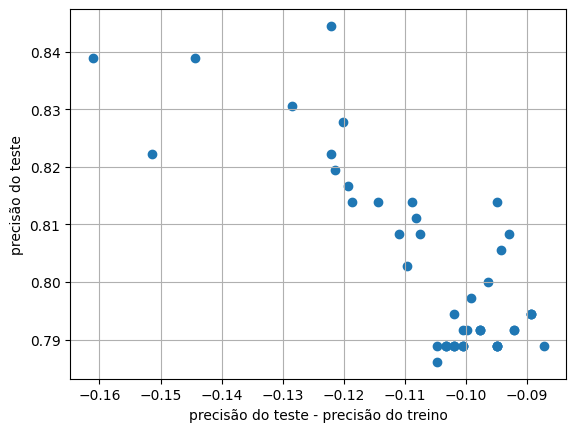

In [43]:
plt.scatter(np.array(precisao) - np.array(precisao_treino), precisao)
plt.ylabel('precisão do teste')
plt.xlabel('precisão do teste - precisão do treino')
plt.grid()
plt.show()

O gráfico abaixo mostra a relação entre a impureza e a diferença entre a precisão do teste e do treino.

Observando o gráfico abaixo, para termos um modelo como baixo overfitting, é preciso aumentar a impureza total até um nível aceitável de precisão do modelo.

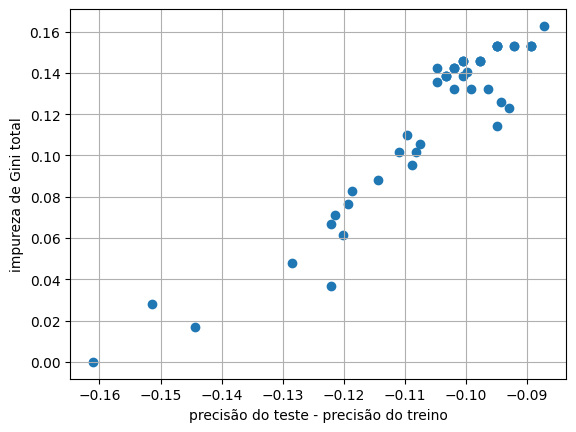

In [44]:
plt.scatter(np.array(precisao) - np.array(precisao_treino), impureza)
plt.ylabel('impureza de Gini total')
plt.xlabel('precisão do teste - precisão do treino')
plt.grid()
plt.show()



#### Exercício 4 - Preparação do container para deploy do modelo
Neste exercício, você irá aprender a preparar um container Docker para deploy do modelo de árvore de decisão treinado. Isso envolve criar um ambiente isolado e portável que possa ser facilmente implantado em diferentes contextos.

Você irá:
1. Criar um arquivo Dockerfile que define as instruções para construir a imagem do container.
2. Especificar as dependências necessárias para o modelo, incluindo bibliotecas e frameworks.
3. Configurar o ambiente de execução do modelo, incluindo a definição de variáveis de ambiente e a configuração de portas.
4. Construir a imagem do container utilizando o comando `docker build`.
5. Executar o container utilizando o comando `docker run` e testar a imagem.

*Dicas:*
- Certifique-se de que o arquivo Dockerfile esteja configurado corretamente para construir a imagem do container.

#### Exercício 5 - Deploy do modelo usando Flask utilizando uma imagem docker
Neste exercício, você irá aprender a deployar o modelo de árvore de decisão treinado utilizando o framework Flask e uma imagem Docker. Isso envolve criar uma API REST que permita realizar inferências com o modelo e entender como funciona o processo de deploy de um modelo em um ambiente de produção.

Você irá:
1. Criar uma aplicação Flask que carregue o modelo treinado e o utilize para realizar inferências.
2. Definir uma API REST que permita enviar solicitações de inferência ao modelo e receber respostas.
3. Configurar a aplicação Flask dentro da imagem Docker do exercício anterior.
4. Deployar a aplicação Flask no container Docker e testar a API REST.
5. Entender como funciona o processo de deploy de um modelo em um ambiente de produção, incluindo a configuração de variáveis de ambiente e a gestão de dependências.

#### Exercício 6 - Notebook cliente com inferência direto do servidor
Neste exercício, você irá aprender a criar um notebook cliente que realize inferências direto do servidor onde o modelo de árvore de decisão foi deployado. Isso envolve entender como funciona o processo de comunicação entre o cliente e o servidor e como realizar inferências com o modelo deployado.

Você irá:
1. Criar um notebook cliente.
2. Importar as bibliotecas necessárias para realizar inferências com o modelo, incluindo a biblioteca `requests` para enviar solicitações HTTP ao servidor criado no exercício anterior.
3. Configurar o notebook cliente para se conectar ao servidor onde o modelo foi deployado.
4. Enviar solicitações de inferência ao servidor utilizando a API REST criada no exercício anterior.
5. Receber as respostas do servidor e visualizar os resultados das inferências.